# Blibliotecas & Downloads


In [2]:
import pandas as pd
import math

import networkx as nx
import matplotlib.pyplot as plt


# Monta arquivo para trabalho

### Dados de aeroporto

In [3]:
airport_col = ['ID', 'Name', 'City', 'Country','IATA', 'ICAO', 'Lat', 'Long', 'Alt',
	               'Timezone', 'DST', 'Tz database time zone', 'type', 'source']
airport_df = pd.read_csv("https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat",
	                        names = airport_col, index_col = 0)
airport_df[airport_df.Country == 'Brazil'].head(20)

,Name,City,Country,IATA,ICAO,Lat,Long,Alt,Timezone,DST,Tz database time zone,type,source
ID,,,,,,,,,,,,,
2518,Conceição do Araguaia Airport,Conceicao Do Araguaia,Brazil,CDJ,SBAA,-8.348350,-49.301498,653,-3,S,America/Belem,airport,OurAirports
2519,Campo Délio Jardim de Mattos Airport,Rio De Janeiro,Brazil,\N,SBAF,-22.875099,-43.384701,110,-3,S,America/Sao_Paulo,airport,OurAirports
2520,Amapá Airport,Amapa,Brazil,\N,SBAM,2.077510,-50.858200,45,-3,S,America/Fortaleza,airport,OurAirports
2521,Araraquara Airport,Araracuara,Brazil,AQA,SBAQ,-21.812000,-48.132999,2334,-3,S,America/Sao_Paulo,airport,OurAirports
2522,Santa Maria Airport,Aracaju,Brazil,AJU,SBAR,-10.984000,-37.070301,23,-3,S,America/Fortaleza,airport,OurAirports
2524,Piloto Osvaldo Marques Dias Airport,Alta Floresta,Brazil,AFL,SBAT,-9.866389,-56.105000,948,-4,S,America/Campo_Grande,airport,OurAirports
2525,Araçatuba Airport,Aracatuba,Brazil,ARU,SBAU,-21.141300,-50.424702,1361,-3,S,America/Sao_Paulo,airport,OurAirports
2526,Val de Cans/Júlio Cezar Ribeiro International ...,Belem,Brazil,BEL,SBBE,-1.379250,-48.476299,54,-3,S,America/Belem,airport,OurAirports
2527,Comandante Gustavo Kraemer Airport,Bage,Brazil,BGX,SBBG,-31.390499,-54.112202,600,-3,S,America/Sao_Paulo,airport,OurAirports


## Dados das rotas

### Arquivo com geolocalizacao

In [4]:
def monta_pos(IATA):
  airport_pos_df = airport_df.loc[airport_df['IATA'].isin(IATA)][['IATA', 'Lat', 'Long']]
  airport_pos_df.reset_index(inplace=True)

  pos = {}
  for index, elem in enumerate (airport_pos_df['IATA']):
    pos[elem] =  (airport_pos_df.loc[index ,'Long'], airport_pos_df.loc[index ,'Lat'])

  found = len(airport_pos_df.loc[~airport_pos_df['Lat'].isnull()])
  print(f'{found} Aeroportos com Lat, Long')

  return pos


### Monta topo de rotas, e prepara a lista de aeroportos

In [5]:
def routes_top(routes_grouped_df, top):
  routes_grouped_df_top = routes_grouped_df.loc[routes_grouped_df['counts'] > top]

  IATA_dest = set(routes_grouped_df_top['IATA_dest'].unique())
  print(f'{len(IATA_dest)} Aeroportos encontrados destinos')

  IATA_orig = set(routes_grouped_df_top['IATA_orig'].unique())
  print(f'{len(IATA_orig)} Aeroportos encontrados origem')

  IATA = IATA_dest.union(IATA_orig)
  print(f'{len(IATA)} Aeroportos encontrados total')
  return IATA, routes_grouped_df_top

### Função principal de montagem de rotas

In [6]:
def monta_rotas(top):
  ######################################################
  # Define nomes mais faceis de manipular para a tabela
  ######################################################
  '''
  0 'ICAO Empresa Aérea'	'Número Voo'	'Código Autorização (DI)'	'Código Tipo Linha'	'ICAO Aeródromo Origem'	'ICAO Aeródromoo Destino'
  'Partida Prevista'	'Partida Real'	'Chegada Prevista'	'Chegada Real'
  'Situação Voo'	'Código Justificativa'	'ano'	'mes'
  '''

  routes_col = ['company_id', 'flight_no', 'auth_code', 'line_code','ICAO_orig', 'ICAO_dest',
                'depature_estimated', 'depature_time', 'arrival_estimated', 'arriaval_time',
                'flight_status', 'flight_status_cause_code', 'ano', 'mes']

  #Carrega a lista do ano, porém eliminando os voos cancelados
  routes_df = pd.read_csv(f"https://github.com/lucianomcsilva/VRA/blob/main/VRA_ANO_2018.csv.zip?raw=true"
                            ,compression='zip' ,header=0 ,names = routes_col, index_col = 0) #

  routes_df = routes_df.loc[routes_df['flight_status'] != 'CANCELADO']

  #Agrupa, mantendo so o que entrara no grafo
  routes_grouped_df = routes_df.groupby(['ICAO_orig', 'ICAO_dest']).size().reset_index(name='counts')

  ######################################################################
  #Jaz a junção com o Airport.dat para trocar para o codigo de 3 letras
  ######################################################################
  #Join origem
  routes_grouped_df = routes_grouped_df.merge(airport_df[['ICAO', 'IATA', 'Lat', 'Long', 'Country']], how='left', left_on='ICAO_orig', right_on='ICAO')
  routes_grouped_df = routes_grouped_df[['IATA', 'Country', 'ICAO_dest', 'counts']]
  routes_grouped_df.rename(columns={'IATA': 'IATA_orig', 'Country': 'Country_orig'}, inplace = True)
  #Join Destino
  routes_grouped_df = routes_grouped_df.merge(airport_df[['ICAO', 'IATA', 'Lat', 'Long', 'Country']], how='left', left_on='ICAO_dest', right_on='ICAO')
  routes_grouped_df = routes_grouped_df[['IATA_orig', 'Country_orig', 'IATA', 'Country', 'counts']]
  routes_grouped_df.rename(columns={'IATA': 'IATA_dest', 'Country': 'Country_dest'}, inplace = True)

  #Filtra somente Brazil, e mantem somente as colunas necessarias
  routes_grouped_df = (routes_grouped_df
                        .loc[routes_grouped_df['Country_orig'] == 'Brazil']
                        .loc[routes_grouped_df['Country_dest'] == 'Brazil']
                        .loc[routes_grouped_df['IATA_orig'] != routes_grouped_df['IATA_dest']]
                        .loc[routes_grouped_df['IATA_orig'].str.len() == 3]
                        .loc[routes_grouped_df['IATA_dest'].str.len() == 3]
                        .sort_values(by=['counts'], ascending=False)
                      )
  routes_grouped_df = routes_grouped_df[['IATA_orig', 'IATA_dest', 'counts']]

  #prepara os DataFrames que serão utilizados
  IATA, routes_grouped_df_top = routes_top(routes_grouped_df, top)
  pos = monta_pos(IATA)
  return routes_grouped_df_top, pos

  #lista de aeroportos nao encontrados
  #routes_grouped_df.loc[routes_grouped_df['ICAO'].isnull()]['ICAO_orig'].to_list()
  #df_anac_2015 = pd.read_csv(f"VRA_ANO_2015.csv")


# Grafos

## monta o grafo

In [7]:
routes, pos = monta_rotas(1)
routes.reset_index(inplace=True)
display(len(routes))
display(len(pos))

<ipython-input-6-7927a09d5b67>:16: DtypeWarning: Columns (2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  routes_df = pd.read_csv(f"https://github.com/lucianomcsilva/VRA/blob/main/VRA_ANO_2018.csv.zip?raw=true"


117 Aeroportos encontrados destinos
116 Aeroportos encontrados origem
118 Aeroportos encontrados total
118 Aeroportos com Lat, Long


1090

118

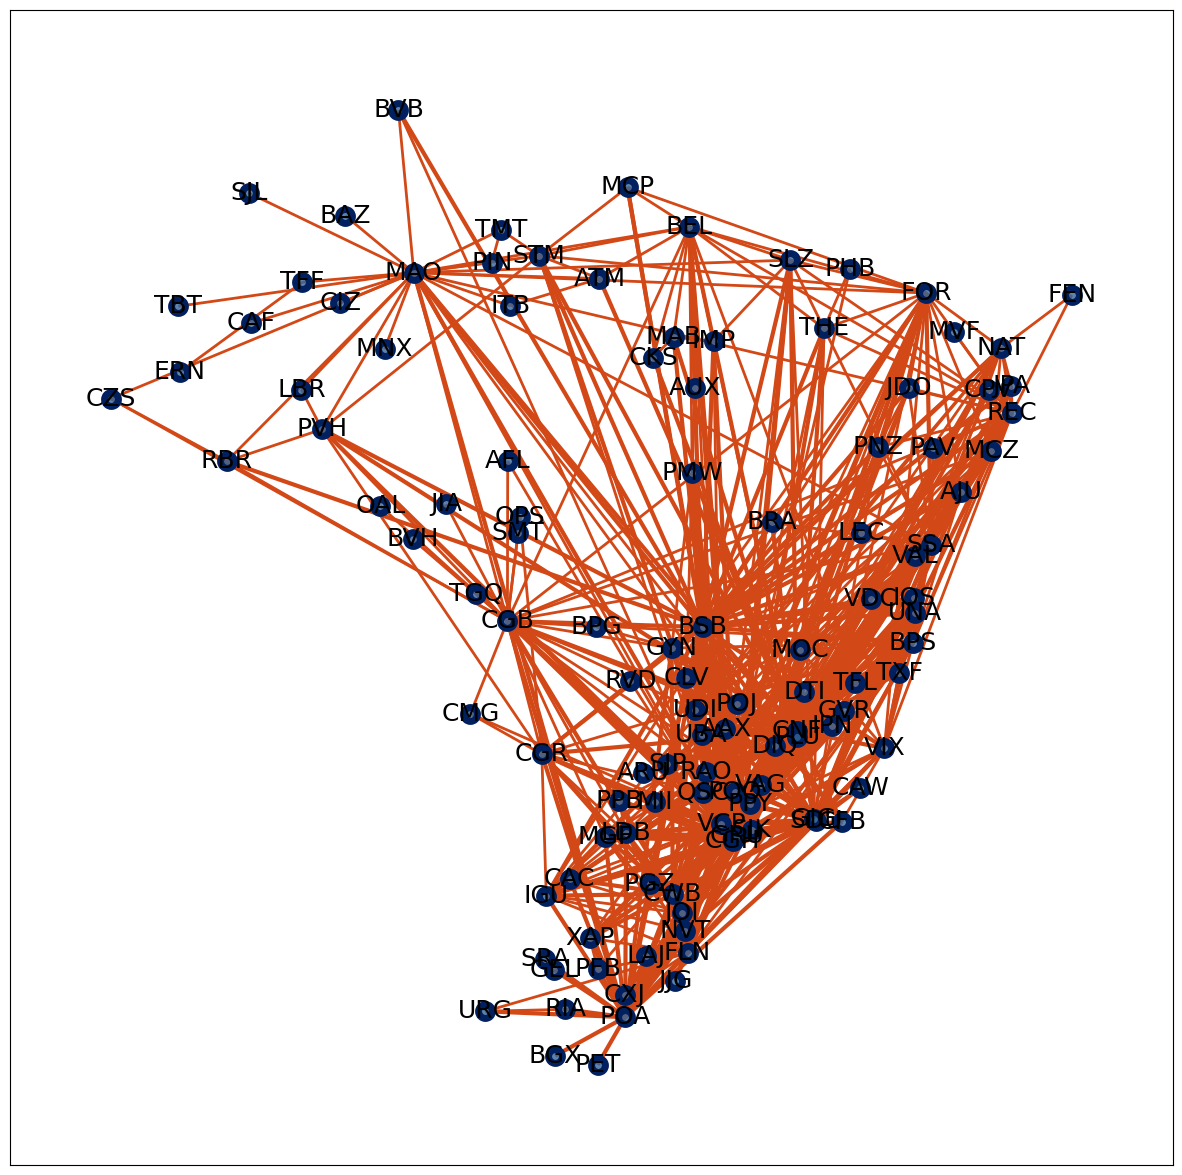

In [8]:
G = nx.Graph()
airport_brasil_df = airport_df.loc[airport_df['Country'] == 'Brazil'].loc[airport_df['IATA'].str.len() == 3]
airport_brasil_df.reset_index(inplace=True)

for index, elem in enumerate(routes['IATA_orig']):
  G.add_edge(routes.loc[index, 'IATA_orig'], routes.loc[index, 'IATA_dest'])

#Dois aeroportos desconexos. Nao faz sentido remover caso desenhe todos os aeroportos, pois haverão outros disconexos (sem voo algum, valencia = 0)
G.remove_node('SXO')
G.remove_node('CFO')

options = {
    "font_size": 18,
    "node_size": 100,
    "node_color": "#336699CC",
    "edgecolors": "#002060",
    "edge_color": "#D34817",
    "linewidths": 5,
    "width": [1+int(math.log(x, 30)) for x in routes['counts'].to_list()],
    "with_labels": True
}

plt.figure(figsize = (15,15))
nx.draw_networkx(G, pos, **options)
#plt.savefig(f'brasil_2_map_{ano}.png', dpi=50)

## Qual o grau médio, ou seja, número de outros aeroportos conectados, dos aeroportos brasileiros com voos em 2018?

In [9]:
import numpy as np

# Calculando o grau de cada nó (aeroporto)
degree_dict = dict(G.degree())

# Calculando o grau médio
degree_values = np.array(list(degree_dict.values()))
average_degree = np.mean(degree_values)

print(f"Grau Médio dos Aeroportos Brasileiros em 2018: {average_degree}")

Grau Médio dos Aeroportos Brasileiros em 2018: 10.293103448275861


## Qual aeroporto brasileiro voava, em 2018, para mais cidades distintas?


In [10]:
# Calculando a centralidade de grau para cada aeroporto
degree_centrality = nx.degree_centrality(G)

# Encontrando o aeroporto com a maior centralidade de grau
max_degree_airport = max(degree_centrality, key=degree_centrality.get)
max_degree_count = G.degree(max_degree_airport)

print(f"Aeroporto Brasileiro que voava para mais cidades distintas em 2018:")
print(f"Aeroporto: {max_degree_airport}")
print(f"Número de cidades distintas: {max_degree_count}")


Aeroporto Brasileiro que voava para mais cidades distintas em 2018:
Aeroporto: VCP
Número de cidades distintas: 67


## Quais são os dois aeroportos que precisavam em 2018 de mais escalas para se interligarem?

In [11]:
# Calculando os caminhos mais curtos entre todos os pares de aeroportos
shortest_paths = dict(nx.shortest_path_length(G))

# Inicializando variáveis para armazenar os aeroportos e o número máximo de escalas
max_stops = 0
pair_of_airports = None

# Iterando sobre todos os pares de aeroportos
for airport1 in G.nodes:
    for airport2 in G.nodes:
        if airport1 != airport2:
            stops = shortest_paths[airport1][airport2]
            if stops > max_stops:
                max_stops = stops
                pair_of_airports = (airport1, airport2)

# Imprimindo os dois aeroportos que precisavam de mais escalas para se interligarem
print(f"Dois aeroportos que precisavam de mais escalas para se interligarem em 2018:")
print(f"Aeroporto 1: {pair_of_airports[0]}, Aeroporto 2: {pair_of_airports[1]}")
print(f"Número máximo de escalas: {max_stops}")

Dois aeroportos que precisavam de mais escalas para se interligarem em 2018:
Aeroporto 1: AUX, Aeroporto 2: ERN
Número máximo de escalas: 5
